We approximate village clusters by running DBSCAN on the 34 x 34 grid (of 300m x 300m tiles, to make a 10200m x 10200m region) containing several boxes, and in particular box centers.

Boxes are labeled by sq number and then by an arbitrary index.

In [1]:
import numpy as np
import pickle
import sys
from PIL import Image
import cv2
from glob import glob
import os
from scipy import spatial

%matplotlib inline

In [2]:
# from hyper import IMG_ID
IMG_ID = 10130002

def box_name(sq, qrt):
    return "boxes/%d/dg_lsms_uganda_1000x1000_%d_%d_%d.pickle" % (IMG_ID, IMG_ID, sq, qrt)

In [3]:
# the sq-1 is because sq is in range [1, 1156]

def get_y(sq, qrt, y):
    return 1000 * ((sq-1) % 34) + 500 * (qrt % 2) + y

def get_x(sq, qrt, x):
    return 1000 * int((sq-1) / 34) + 500 * int(qrt / 2) + x

In [4]:
from hyper import NUM_SQ

X = np.zeros([1, 2])  # don't forget to remove this at the end

for sq in range(1, NUM_SQ+1):  # update to len(val_files)
    for qrt in range(4):
        
        file = box_name(sq, qrt)
        
        # in case the object detector was unable to open the image
        if not os.path.exists(file): continue
        
        pickle_in = open(file, "rb")
        boxes = pickle.load(pickle_in)
        
        if boxes is not None:   # boxes exist in this tile
            for box in boxes:
                # size = (box.xmax - box.xmin) * (box.ymax - box.ymin)
                # if size > HOUSE_SIZE_THRESH: continue
                
                temp = np.zeros([1, 2])
                x = np.mean([box.xmin, box.xmax])
                y = np.mean([box.ymin, box.ymax])
                
                temp[0, 0] = get_x(sq, qrt, x)
                temp[0, 1] = get_y(sq, qrt, y)
                X = np.concatenate((X, temp))
            
            
X = np.delete(X, (0), axis=0)  # didn't forget :)

In [5]:
metrics = {}
metrics['num_houses'] = X.shape[0]
print("Total number of houses =", metrics['num_houses'])

Total number of houses = 478


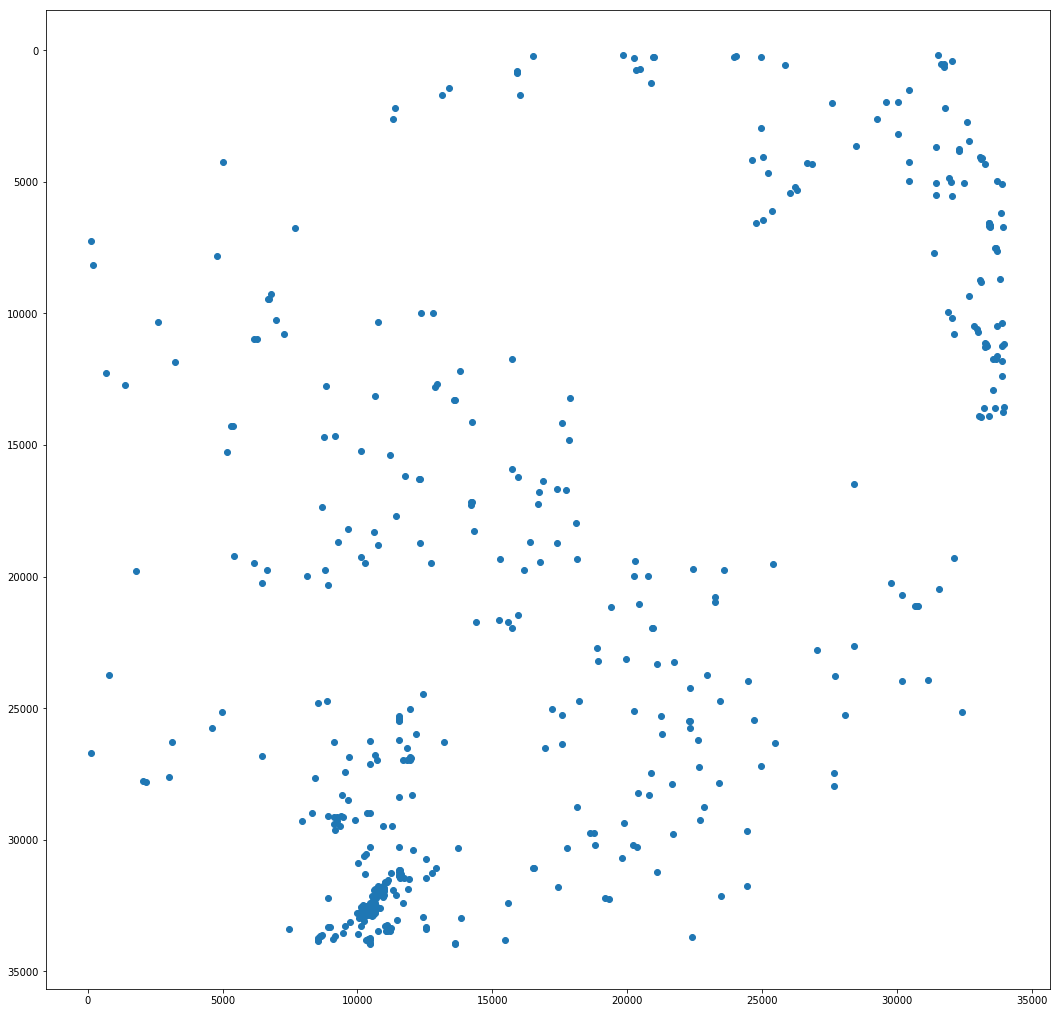

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 18]
plt.gca().invert_yaxis()

# X[:,1] = -X[:,1]

plt.scatter(X[:,0], X[:,1])
plt.show()

Opening the img_id zone in Google Maps to compare to the distribution above

In [7]:
import pandas as pd
csv = pd.read_csv('Uganda2012Consumption_cluster.csv')

def get_ll(img_id):
    (idx,) = np.where(csv.values[:, 0] == img_id)
    idx = idx.astype(np.uint32)[0]
    return csv.values[idx, 4:6]

In [19]:
import webbrowser

x = IMG_ID
# x = 20130009

(lat, lon) = get_ll(x)
zoom = "10000m"
url = "https://www.google.com/maps/@%.6f,%.6f,%s/data=!3m1!1e3" % (lat, lon, zoom)

print("Current zone available at", url)

webbrowser.open_new_tab(url)

Current zone available at https://www.google.com/maps/@-0.269275,32.309685,10000m/data=!3m1!1e3


False

# DBSCAN Clustering

In [9]:
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

dist_max = 200 # meters

db = cluster.DBSCAN(eps=dist_max / 0.3, min_samples=4)
db.fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

https://en.wikipedia.org/wiki/Silhouette_(clustering)

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object lies within its cluster.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

In [10]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 15


In [11]:
# Plot result
def display(X, labels, core_samples_mask):
    plt.rcParams['figure.figsize'] = [18, 18]
    plt.gca().invert_yaxis()
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    # print("unique labels = ", unique_labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    # print(colors)
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=8)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)

    ax = plt.subplot()
    ax.axis('equal')
    plt.show()

/home/vinceranga/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


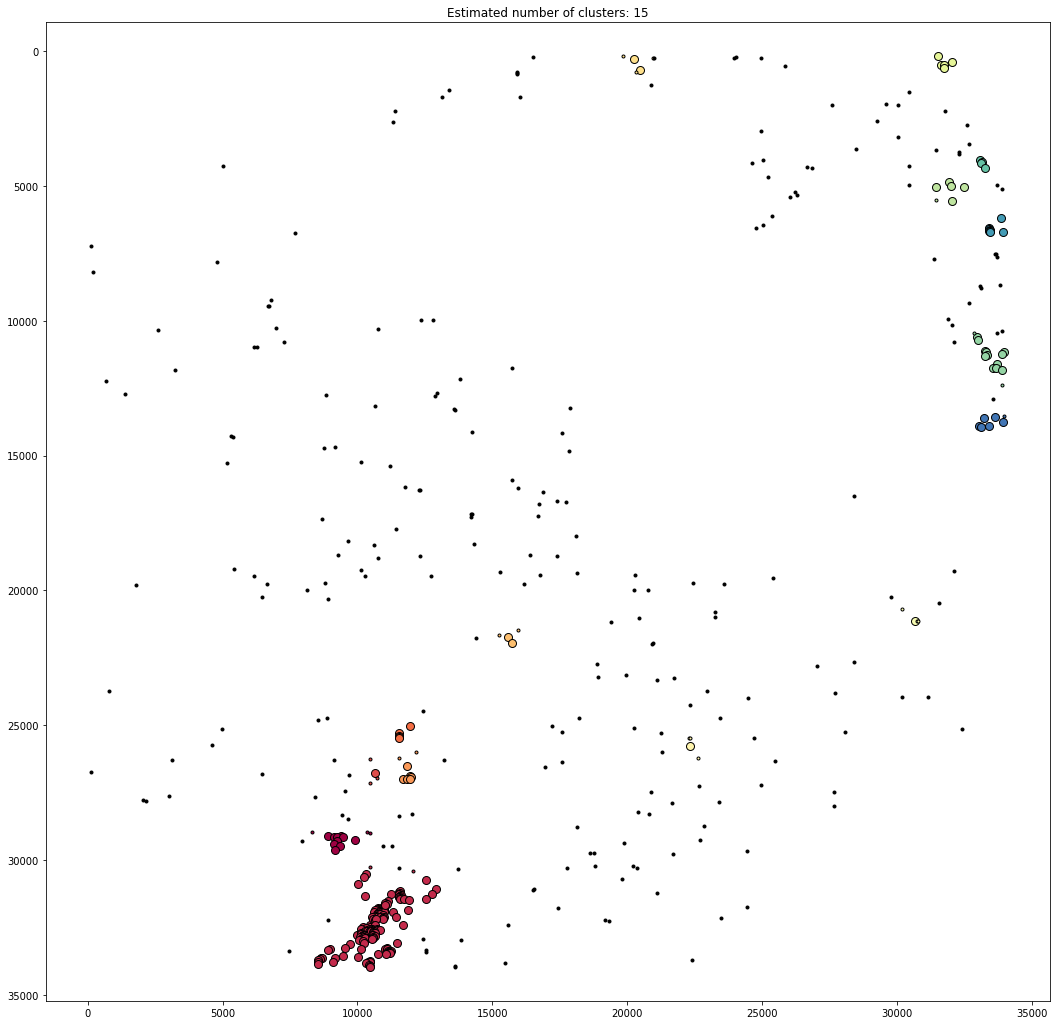

In [12]:
display(X, labels, core_samples_mask)

In [13]:
X_dnsd = X[labels >= 0]
csm_dnsd = core_samples_mask[labels >= 0]
labels_dnsd = labels[labels >= 0]
print("Number of denoised =", X_dnsd.shape[0])

# labels_tops_mask = labels_dnsd

Number of denoised = 233


/home/vinceranga/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


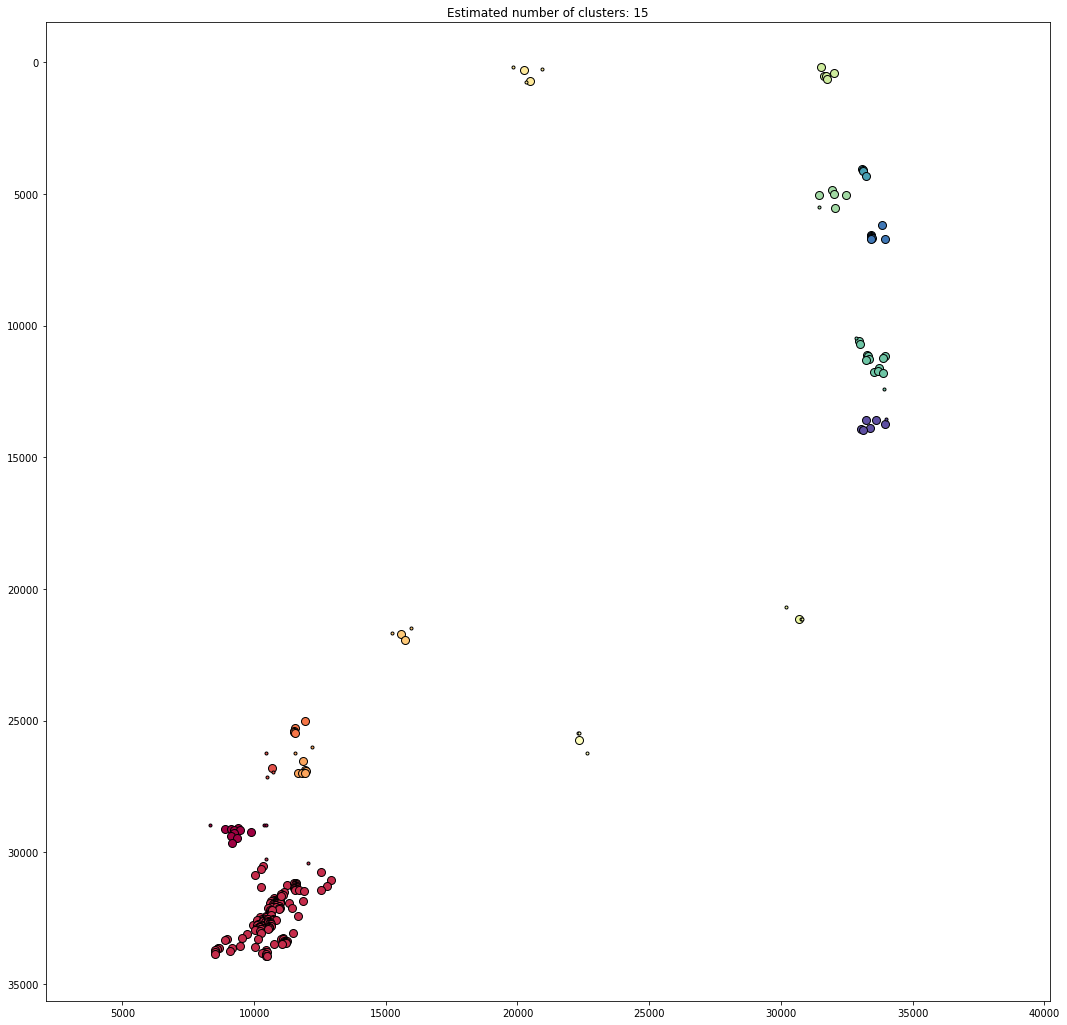

In [14]:
display(X_dnsd, labels_dnsd, csm_dnsd)

In [15]:
def surrounding_tiles(n, k=3):
    tiles = []
    low =  int(-(k-1)/2)
    high = int((k+1)/2)
    
    for i in range(low, high):  # rows
        row = []
        
        for j in range(low, high):  # columns
            y = n%34 if (n%34 > 0) else 34  # 1 to 34
            x = int(n / 34)                 # 0 to 33
            
            if (0 <= x+j <= 33) and (1 <= y+i <= 34):
                tile = 34*(x+j) + (y+i)
                row.append(tile)
            else:
                row.append(-1)

        tiles.append(row)
                
    return tiles

In [25]:
def stitch_tiles(n, k=3, boxed=True):
    all_tiles = surrounding_tiles(n, k)
    # print("stitching:", all_tiles)
    
    imgs = []
    for r in range(k):
        row = all_tiles[r]
        temp = []
        
        for c in range(k):
            if row[c] == -1:
                temp.append(cv2.imread('empty.jpeg'))
            else:
                fname = None
                if not boxed:
                    fname = 'LSMS/dg_lsms_uganda_1000x1000_%d_%d.jpeg' % (IMG_ID, row[c])
                else:
                    quart_names = 'box_imgs/dg_lsms_uganda_1000x1000_%d_%d_*.jpeg' % (IMG_ID, row[c])
                    quart = [cv2.imread(im) for im in sorted(glob(quart_names))]
                    connect_four = np.concatenate([np.concatenate([quart[0], quart[1]], axis=1),
                                                   np.concatenate([quart[2], quart[3]], axis=1)], axis=0)
                    temp.append(connect_four)

        row_cat = np.concatenate(temp, axis=1)
        imgs.append(row_cat)
    
    return np.concatenate(imgs, axis=0)

In [64]:
def most_populated(num_tops=1, k=5, save_imgs=True):
    (values,counts) = np.unique(labels_dnsd,return_counts=True)
    arg = counts.argsort()[-num_tops:][::-1]
    
    for idx in range(num_tops):
        print("%s-th most populated village is %s with a house count of %s" % (idx+1, values[arg[idx]], counts[arg[idx]]))
        
        x, y = np.mean(X_dnsd[labels_dnsd == values[arg[idx]]], axis=0)
        print("x = %.2f, y = %.2f" % (x, y))
        main_sq = int(y / 1000)+1 + 34*int(x / 1000)
        print("main square = %s" % main_sq)
        print()
        
        if save_imgs:
            stitched = Image.fromarray(stitch_tiles(main_sq, k, boxed=True))
            stitched.save("test-out/dg_lsms_uganda_1000x1000_%s_tops%sx%s-%s_%s.jpeg" % (IMG_ID, k, k, idx+1, main_sq))

In [65]:
num_tops = 5

most_populated(num_tops, save_imgs=False)

1-th most populated village is 1 with a house count of 142
x = 10643.29, y = 32442.05
main square = 373

2-th most populated village is 11 with a house count of 14
x = 33467.60, y = 11309.86
main square = 1134

3-th most populated village is 0 with a house count of 13
x = 9385.83, y = 29196.62
main square = 336

4-th most populated village is 13 with a house count of 8
x = 33543.97, y = 6589.42
main square = 1129

5-th most populated village is 4 with a house count of 8
x = 11863.98, y = 26681.07
main square = 401



In [66]:
(values,counts) = np.unique(labels_dnsd,return_counts=True)
tops = counts.argsort()[-num_tops:][::-1]
print(tops)

[ 1 11  0 13  4]


In [67]:
# terrible loopy way of doing this, but python was complaining about the other reasonable approaches soooo

X_tops = np.zeros([1, 2])

labels_tops = []
csm_tops = []
for _ in range(len(labels_dnsd)):
    if labels_dnsd[_] in tops:
        temp = X_dnsd[_].reshape((1, 2))
        X_tops = np.concatenate((X_tops, temp))
        labels_tops.append(labels_dnsd[_])
        csm_tops.append(csm_dnsd[_])
        
X_tops = np.delete(X_tops, (0), axis=0)  # didn't forget :)
labels_tops = np.array(labels_tops)
csm_tops = np.array(csm_tops)

/home/vinceranga/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


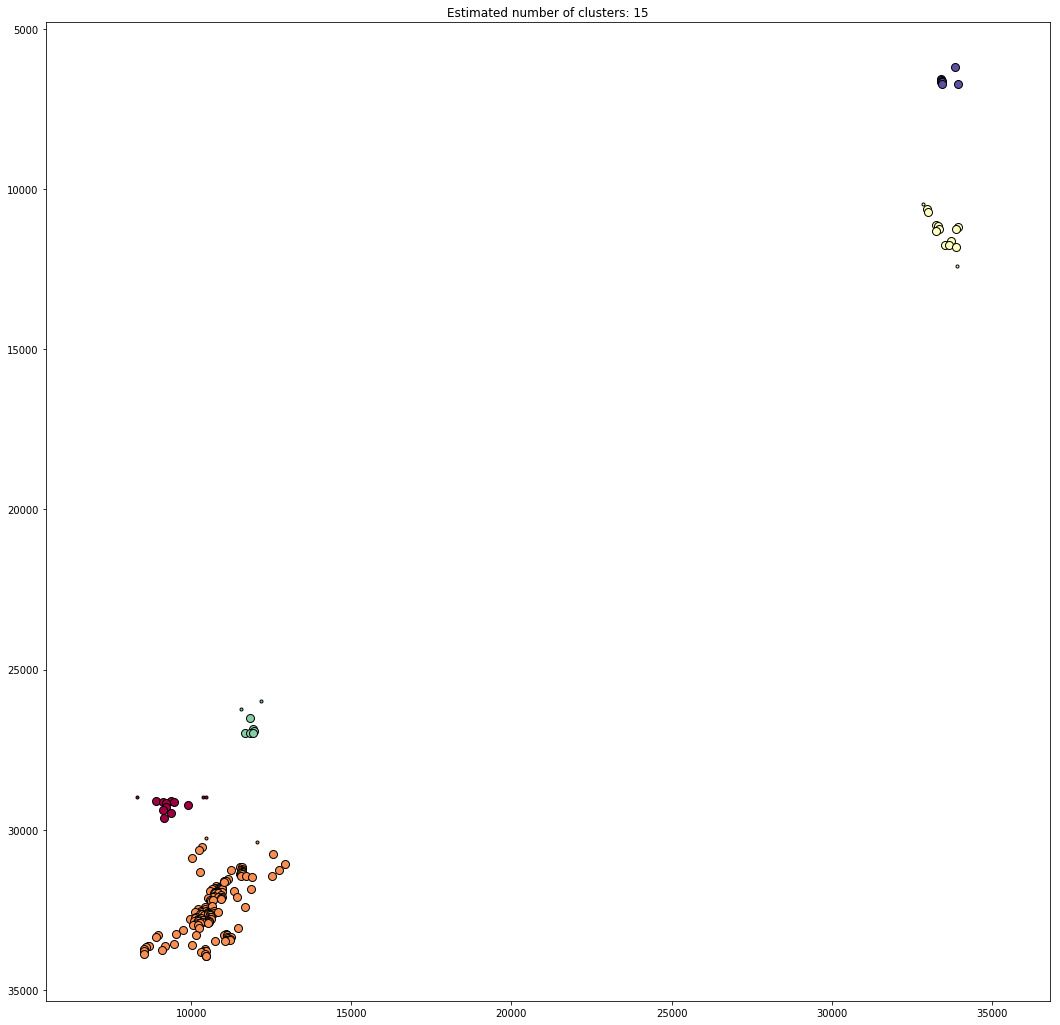

In [68]:
display(X_tops, labels_tops, csm_tops)

# Measuring densities of houses within clusters

The definition for "density" here is the average distance from each house to its closest neighbor. Alternate definitions such as average distance from the center of the cluster are unable to capture the essence of density for oddly-shaped clusters.

In [60]:
def cluster_density(X):
    # X should be of shape (n,m) where n=points in cluster, m=dimensions
    n,m = X.shape
    out = np.zeros((n,))
    
    for i in range(n):
        X_alt = np.delete(X, i, axis=0)
        out[i], _ = spatial.KDTree(X_alt).query(X[i])
    out *= 0.3
        
    return (np.mean(out), np.std(out))

In [61]:
for cluster in range(n_clusters_):
    X_test = X[labels == cluster]
    labels_test = labels[labels == cluster]
    density, std = cluster_density(X_test)
    print("Cluster %d: Mean and std of distance from house to nearest neighbor = %.1fm, %.1fm" %(cluster, density, std))

Cluster 0: Mean and std of distance from house to nearest neighbor = 61.2m, 43.6m
Cluster 1: Mean and std of distance from house to nearest neighbor = 29.7m, 31.4m
Cluster 2: Mean and std of distance from house to nearest neighbor = 92.7m, 47.7m
Cluster 3: Mean and std of distance from house to nearest neighbor = 42.8m, 49.2m
Cluster 4: Mean and std of distance from house to nearest neighbor = 70.3m, 59.7m
Cluster 5: Mean and std of distance from house to nearest neighbor = 100.0m, 21.6m
Cluster 6: Mean and std of distance from house to nearest neighbor = 107.8m, 56.3m
Cluster 7: Mean and std of distance from house to nearest neighbor = 69.7m, 62.6m
Cluster 8: Mean and std of distance from house to nearest neighbor = 62.3m, 79.4m
Cluster 9: Mean and std of distance from house to nearest neighbor = 58.5m, 34.9m
Cluster 10: Mean and std of distance from house to nearest neighbor = 113.3m, 44.4m
Cluster 11: Mean and std of distance from house to nearest neighbor = 45.7m, 37.2m
Cluster 12:

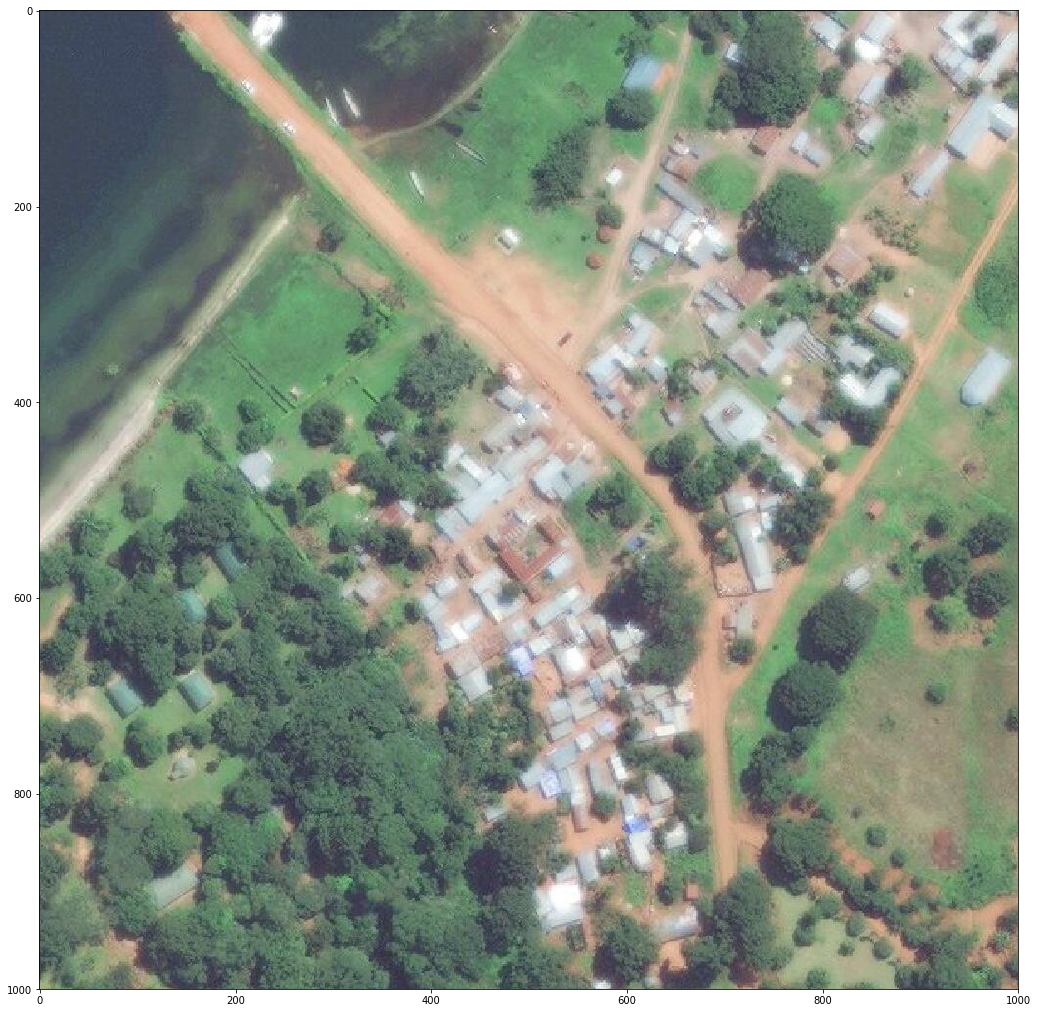

In [74]:
'''
import matplotlib.image as mpimg
img = mpimg.imread('LSMS_dg/dg_lsms_uganda_1000x1000_10130002_373.jpeg')
imgplot = plt.imshow(img, zorder=1)

plt.show()
'''